# 모델 저장

- 학습한 모델을 저장장치에 파일로 저장하고 나중에 불러와 사용(추가 학습, 예측 서비스) 할 수 있도록 한다. 
- 파이토치는 모델의 파라미터만 저장하는 방법과 모델 구조와 파라미터 모두를 저장하는 두가지 방식을 제공한다.
- 저장 함수
    - `torch.save(저장할 객체, 저장경로)`
- 보통 저장파일의 확장자는 `pt`나 `pth` 를 지정한다.

## 모델 전체 저장하기 및 불러오기

- 저장하기
    - `torch.save(model, 저장경로)`
- 불러오기
    - `load_model = torch.load(저장경로)`
- 저장시 **pickle**을 이용해 직렬화하기 때문에 불어오는 실행환경에도 모델을 저장할 때 사용한 클래스가 있어야 한다.



## 모델의 파라미터만 저장
- 모델을 구성하는 파라미터만 저장한다.
- 모델의 구조는 저장하지 않기 때문에 불러올 때 **모델을 먼저 생성하고 생성한 모델에 불러온 파라미터를 덮어씌운다.**
- 모델의 파라미터는 **state_dict** 형식으로 저장한다.

### state_dict
- 모델의 파라미터 Tensor들을 레이어 단위별로 나누어 저장한 Ordered Dictionary (OrderedDict)
- `모델객체.state_dict()` 메소드를 이용해 조회한다.
- 모델의 state_dict을 조회 후 저장한다.
    - `torch.save(model.state_dict(), "저장경로")`
- 생성된 모델에 읽어온 state_dict를 덮어씌운다.
    - `new_model.load_state_dict(torch.load("state_dict저장경로"))`


In [9]:
import torch
import torch.nn as nn

class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.in_layer = nn.Linear(784, 64)
        self.out = nn.Linear(64, 10)
    
    def forward(self, X):
        X = torch.flatten(X, start_dim=1)
        X = nn.ReLU()(self.in_layer(X))
        X = self.out(X)
        return X

In [10]:
sample_model = Network()
sample_model

Network(
  (in_layer): Linear(in_features=784, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
# state_dict 조회
sd = sample_model.state_dict()
print(type(sd))
sd.keys()

<class 'collections.OrderedDict'>


odict_keys(['in_layer.weight', 'in_layer.bias', 'out.weight', 'out.bias'])

In [12]:
sd['in_layer.weight'].shape, sd['in_layer.bias'].shape

(torch.Size([64, 784]), torch.Size([64]))

In [13]:
sample_model.parameters()

<generator object Module.parameters at 0x000001CB0A21D850>

In [14]:
sample_model.in_layer.weight
sample_model.in_layer.bias

Parameter containing:
tensor([ 0.0055,  0.0246, -0.0072, -0.0142, -0.0218,  0.0126,  0.0249, -0.0322,
         0.0211,  0.0097, -0.0193,  0.0220, -0.0068, -0.0100, -0.0125,  0.0239,
        -0.0040,  0.0238, -0.0121,  0.0220,  0.0180,  0.0205,  0.0301,  0.0046,
        -0.0354, -0.0190, -0.0125,  0.0032, -0.0087, -0.0123, -0.0008, -0.0132,
        -0.0321, -0.0076, -0.0132, -0.0089, -0.0293, -0.0228, -0.0021, -0.0180,
         0.0047, -0.0042, -0.0003, -0.0150, -0.0047, -0.0205, -0.0142,  0.0205,
        -0.0019, -0.0147,  0.0291, -0.0250,  0.0012,  0.0170,  0.0240,  0.0094,
        -0.0316,  0.0333,  0.0057, -0.0159, -0.0007,  0.0087,  0.0045, -0.0062],
       requires_grad=True)

# Checkpoint를 저장 및 불러오기
- 학습이 끝나지 않은 모델을 저장 후 나중에 이어서 학습시킬 경우에는 모델의 구조, 파라미터 뿐만 아니라 optimizer, loss 함수등 학습에 필요한 객체들을 저장해야 한다.
- Dictionary에 필요한 요소들을 key-value 쌍으로 저장후 `torch.save()`를 이용해 저장한다.
```python
# 저장
torch.save({
    'epoch':epoch,
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),
    'loss':train_loss
}, "저장경로")

# 불러오기
model = MyModel()
optimizer = optim.Adam(model.parameter())

checkpoint = torch.load("저장경로")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#### 이어학습
model.train()
#### 추론
model.eval()

```

# 문제 유형별 MLP 네트워크
- MLP(Multi Layer Perceptron)
    - Fully Connected Layer로 구성된 네트워크

In [89]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchinfo


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cpu


# Regression(회귀)

## Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
<br><br>
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

## Dataset, DataLoader 생성

In [24]:
boston = pd.read_csv('data/boston_hosing.csv')
boston.shape

X_boston = boston.drop(columns='MEDV').values
y_boston = boston['MEDV'].values.reshape(-1, 1) # 2차원
X_boston.shape, y_boston.shape

((506, 13), (506, 1))

In [25]:
# train/test set 분리
X_train, X_test, y_train, y_test = train_test_split(X_boston, y_boston,
                                                    test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(404, 13) (404, 1) (102, 13) (102, 1)


In [26]:
# feature scaling 
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
# y를 Tensor 타입으로 변환.
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [27]:
# Dataset
boston_train_set = TensorDataset(X_train_scaled, y_train_tensor)
boston_test_set = TensorDataset(X_test_scaled, y_test_tensor)
print(len(boston_train_set), len(boston_test_set))
print(boston_train_set[0])

# DataLoader
boston_train_loader = DataLoader(boston_train_set, batch_size=200, 
                                 shuffle=True, drop_last=True)
boston_test_loader = DataLoader(boston_test_set, batch_size=len(boston_test_set))
len(boston_train_loader), len(boston_test_loader)  # epoch 당 step 수 

404 102
(tensor([-0.3726, -0.4996, -0.7049,  3.6645, -0.4249,  0.9357,  0.6937, -0.4372,
        -0.1622, -0.5617, -0.4846,  0.3717, -0.4110]), tensor([26.7000]))


(2, 1)

## 모델 정의

In [28]:
X_boston.shape

(506, 13)

In [29]:
class BostonModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # 입력 layer => in_feature: input data의 feature개수에 맞춘다.
        self.lr1 = nn.Linear(13, 32)   # input
        # Hidden layer => in_feature: 앞 Layer의 out_feature 개수에 맞춘다.
        self.lr2 = nn.Linear(32, 16)  
        # output layer => out_feature: 모델의 최종 출력 개수에 맞춘다. (집값 1개->1)
        self.lr3 = nn.Linear(16, 1)
    
        
    def forward(self, X):
        # input layer
        out = self.lr1(X)
        out = nn.ReLU()(out)
        # hidden
        out = self.lr2(out)
        out = nn.ReLU()(out)
        # output -> 회귀처리 모델에서 output layer에서는 활성함수를 적용하지 않는다.
        #   예외: 출력결과가 특정 활성함수의 출력과 매칭될 경우.
        #        output: 0 ~ 1 => logistic 함수사용.
        #        output: -1 ~ 1=> hyperbolic tangent (tanh)
        out  = self.lr3(out)
        return out

In [30]:
boston_model = BostonModel()
torchinfo.summary(boston_model, (200, 13))  #(모델, 입력데이터shape-(batch size, feature) )

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [200, 1]                  --
├─Linear: 1-1                            [200, 32]                 448
├─Linear: 1-2                            [200, 16]                 528
├─Linear: 1-3                            [200, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

## 학습

In [31]:
N_EPOCH = 1000
LR = 0.001
# 결과 저장할 리스트
train_loss_list = []
val_loss_list = []

# 모델, loss함수(회귀-MSE), optimizer
boston_model = BostonModel()
boston_model = boston_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(boston_model.parameters(), lr=LR)

In [32]:
# 학습: 두단계 - 학습 + 검증
for epoch in range(N_EPOCH):
    ################
    # 학습 - 모델을 train 모드로 변경
    ################
    boston_model.train()
    train_loss = 0.0
    for X, y in boston_train_loader:
        # X, y를 device로 이동
        X, y = X.to(device), y.to(device)
        # 1. 모델 추정
        pred = boston_model(X) # 순전파(forward propagation)
        # 2. loss 계산
        loss = loss_fn(pred, y)  # 추정, 정답
        # 3. 모델 파라미터를 업데이트
        ## 3.1 파라미터들의 기울기를 초기화
        optimizer.zero_grad()
        ## 3.2 역전파(back propagration)을 해서 파라미터들의 기울기를 계산(grad속성에 저장)
        loss.backward()
        ## 3.3 파라미터 업데이트 처리.=> 1 step
        optimizer.step()
        
        train_loss += loss.item()
    #평균 loss
    train_loss /= len(boston_train_loader)
    # 1 epoch 학습끝
    ###############################
    # 검증 - 모델을 평가모드로 변경
    ###############################
    boston_model.eval() #evalutation mode 로 변환
    val_loss = 0.0
    # 역전파를 통한 gradient 계산이 필요 없기 때문에 일시적으로 grad_fn 을 구하지 않도록 처리.
    with torch.no_grad():
        for X_val, y_val in boston_test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            # 1.추정
            pred_val = boston_model(X_val)
            # 2. loss 계산
            val_loss += loss_fn(pred_val, y_val).item()
        val_loss /= len(boston_test_loader)
    # epoch에 대한 검증 완료
    # 결과 출력
    print(f"[{epoch+1}/{N_EPOCH}] train loss: {train_loss:.5f}, val loss: {val_loss:.5f}")
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

[1/1000] train loss: 595.98843, val loss: 566.95111
[2/1000] train loss: 585.96432, val loss: 560.97638
[3/1000] train loss: 579.13293, val loss: 553.27539
[4/1000] train loss: 569.53342, val loss: 544.35529
[5/1000] train loss: 562.20175, val loss: 534.11798
[6/1000] train loss: 549.77957, val loss: 522.74512
[7/1000] train loss: 533.58051, val loss: 510.18384
[8/1000] train loss: 520.68010, val loss: 496.31909
[9/1000] train loss: 503.73001, val loss: 481.61789
[10/1000] train loss: 485.39366, val loss: 466.17053
[11/1000] train loss: 469.57910, val loss: 449.87064
[12/1000] train loss: 451.25645, val loss: 433.05493
[13/1000] train loss: 431.95697, val loss: 415.92972
[14/1000] train loss: 413.01254, val loss: 398.61359
[15/1000] train loss: 390.09718, val loss: 381.34540
[16/1000] train loss: 372.66281, val loss: 364.19467
[17/1000] train loss: 351.85046, val loss: 347.31561
[18/1000] train loss: 334.90665, val loss: 330.93991
[19/1000] train loss: 316.14717, val loss: 315.11990
[2

[179/1000] train loss: 15.82525, val loss: 38.15768
[180/1000] train loss: 15.77191, val loss: 38.10442
[181/1000] train loss: 17.72330, val loss: 37.89149
[182/1000] train loss: 17.34617, val loss: 37.75267
[183/1000] train loss: 17.48574, val loss: 37.54773
[184/1000] train loss: 17.41839, val loss: 37.36388
[185/1000] train loss: 17.25684, val loss: 37.23611
[186/1000] train loss: 17.05553, val loss: 37.02721
[187/1000] train loss: 16.98470, val loss: 36.86789
[188/1000] train loss: 16.66148, val loss: 36.60552
[189/1000] train loss: 16.84660, val loss: 36.39700
[190/1000] train loss: 16.63506, val loss: 36.25280
[191/1000] train loss: 16.76292, val loss: 36.10757
[192/1000] train loss: 16.69900, val loss: 35.91133
[193/1000] train loss: 16.49074, val loss: 35.77885
[194/1000] train loss: 16.35272, val loss: 35.66690
[195/1000] train loss: 16.40522, val loss: 35.50103
[196/1000] train loss: 16.26142, val loss: 35.35899
[197/1000] train loss: 16.10258, val loss: 35.23485
[198/1000] t

[374/1000] train loss: 7.95827, val loss: 22.04703
[375/1000] train loss: 8.02470, val loss: 22.09136
[376/1000] train loss: 8.01566, val loss: 22.11902
[377/1000] train loss: 7.18320, val loss: 21.82494
[378/1000] train loss: 7.83867, val loss: 21.74149
[379/1000] train loss: 7.72456, val loss: 21.77267
[380/1000] train loss: 7.64978, val loss: 21.78260
[381/1000] train loss: 7.74826, val loss: 21.73410
[382/1000] train loss: 7.85620, val loss: 21.58802
[383/1000] train loss: 7.79765, val loss: 21.65141
[384/1000] train loss: 7.76491, val loss: 21.77954
[385/1000] train loss: 7.70414, val loss: 21.69217
[386/1000] train loss: 7.77459, val loss: 21.56166
[387/1000] train loss: 7.83761, val loss: 21.54135
[388/1000] train loss: 7.54037, val loss: 21.78086
[389/1000] train loss: 7.74448, val loss: 21.57654
[390/1000] train loss: 7.68789, val loss: 21.53693
[391/1000] train loss: 7.68191, val loss: 21.59384
[392/1000] train loss: 7.56543, val loss: 21.60981
[393/1000] train loss: 7.61920,

[561/1000] train loss: 6.09726, val loss: 18.86405
[562/1000] train loss: 6.02506, val loss: 19.18291
[563/1000] train loss: 5.99416, val loss: 19.04234
[564/1000] train loss: 5.95478, val loss: 19.19717
[565/1000] train loss: 5.94659, val loss: 19.12503
[566/1000] train loss: 5.98617, val loss: 18.94293
[567/1000] train loss: 5.93993, val loss: 19.20661
[568/1000] train loss: 5.97086, val loss: 19.01809
[569/1000] train loss: 5.93331, val loss: 19.13983
[570/1000] train loss: 6.00562, val loss: 18.84715
[571/1000] train loss: 5.90841, val loss: 19.10770
[572/1000] train loss: 5.88611, val loss: 19.14014
[573/1000] train loss: 5.89920, val loss: 18.95596
[574/1000] train loss: 5.77494, val loss: 19.03388
[575/1000] train loss: 5.82245, val loss: 18.94030
[576/1000] train loss: 5.91084, val loss: 19.19888
[577/1000] train loss: 5.84108, val loss: 18.83499
[578/1000] train loss: 5.90164, val loss: 18.84518
[579/1000] train loss: 5.89197, val loss: 18.84802
[580/1000] train loss: 5.86432,

[758/1000] train loss: 5.07018, val loss: 18.15623
[759/1000] train loss: 5.02577, val loss: 18.12817
[760/1000] train loss: 5.05304, val loss: 18.21564
[761/1000] train loss: 4.99788, val loss: 18.13814
[762/1000] train loss: 5.03778, val loss: 18.17868
[763/1000] train loss: 5.05916, val loss: 17.97842
[764/1000] train loss: 5.02410, val loss: 17.95360
[765/1000] train loss: 4.98758, val loss: 18.24920
[766/1000] train loss: 5.23430, val loss: 18.53022
[767/1000] train loss: 5.03149, val loss: 18.03701
[768/1000] train loss: 4.99681, val loss: 18.12316
[769/1000] train loss: 4.99950, val loss: 18.08280
[770/1000] train loss: 5.03949, val loss: 18.22523
[771/1000] train loss: 5.06698, val loss: 18.36231
[772/1000] train loss: 5.01230, val loss: 18.02382
[773/1000] train loss: 4.96474, val loss: 18.09958
[774/1000] train loss: 5.08864, val loss: 17.78070
[775/1000] train loss: 5.04510, val loss: 17.83757
[776/1000] train loss: 5.04681, val loss: 18.06652
[777/1000] train loss: 4.93180,

[938/1000] train loss: 4.33550, val loss: 17.80559
[939/1000] train loss: 4.49593, val loss: 17.69877
[940/1000] train loss: 4.45337, val loss: 17.66805
[941/1000] train loss: 4.42290, val loss: 17.57561
[942/1000] train loss: 4.42722, val loss: 17.79920
[943/1000] train loss: 4.47690, val loss: 17.75064
[944/1000] train loss: 4.53220, val loss: 18.00628
[945/1000] train loss: 4.48450, val loss: 17.55511
[946/1000] train loss: 4.45097, val loss: 17.66934
[947/1000] train loss: 4.36518, val loss: 17.85658
[948/1000] train loss: 4.46994, val loss: 17.66122
[949/1000] train loss: 4.49441, val loss: 17.90595
[950/1000] train loss: 4.44112, val loss: 17.86518
[951/1000] train loss: 4.46247, val loss: 17.42081
[952/1000] train loss: 4.43557, val loss: 17.59121
[953/1000] train loss: 4.39266, val loss: 17.57538
[954/1000] train loss: 4.35237, val loss: 17.53146
[955/1000] train loss: 4.40345, val loss: 17.81173
[956/1000] train loss: 4.46774, val loss: 17.46971
[957/1000] train loss: 4.32827,

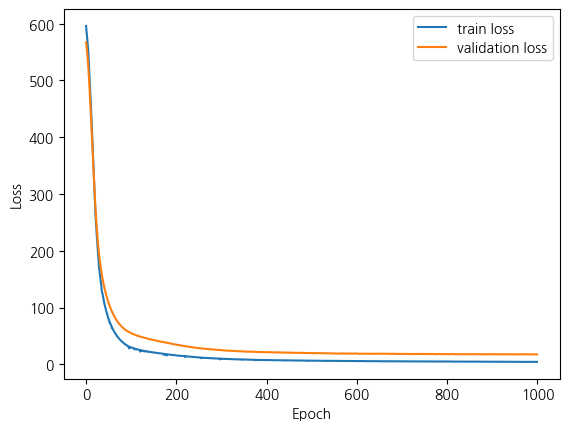

In [33]:
import matplotlib.pyplot as plt

plt.plot(range(N_EPOCH), train_loss_list, label="train loss")
plt.plot(range(N_EPOCH), val_loss_list, label="validation loss")
plt.xlabel("Epoch")
plt.ylabel('Loss')
# plt.ylim(3, 30)
plt.legend()
plt.show()

# 모델 저장

## 모델 전체 저장 및 불러오기
- 모델구조, 파라미터 저장


In [34]:
save_path = 'models/boston_model.pt'
torch.save(boston_model, save_path)

In [35]:
load_boston_model_1 = torch.load(save_path)

In [36]:
torchinfo.summary(load_boston_model_1, (200, 13))

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [200, 1]                  --
├─Linear: 1-1                            [200, 32]                 448
├─Linear: 1-2                            [200, 16]                 528
├─Linear: 1-3                            [200, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [37]:
val_loss = 0.0
load_boston_model_1.to(device)
load_boston_model_1.eval()
with torch.no_grad():
    for X_val, y_val in boston_test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        # 1.추정
        pred_val = load_boston_model_1(X_val)
        # 2. loss 계산
        val_loss += loss_fn(pred_val, y_val).item()
    val_loss /= len(boston_test_loader)

In [38]:
val_loss

17.577037811279297

## state_dict 저장 및 로딩
- 모델 파라미터만 저장

In [39]:
save_path2 = "models/boston_state_dict.pt"
model_sd = boston_model.state_dict()

torch.save(model_sd, save_path2)

In [40]:
#state_dict 를 로딩 
## 1. 모델객체 생성
load_boston_model_2 = BostonModel().to(device)
## 2. state_dict 불러오기
load_sd = torch.load(save_path2)
## 3. 불러온 state_dict(파라미터들)을 모델에 덮어 씌우기
load_boston_model_2.load_state_dict(load_sd)

<All keys matched successfully>

In [41]:
val_loss = 0.0
load_boston_model_2.to(device)
load_boston_model_2.eval() #평가모드 변환
with torch.no_grad():
    for X_val, y_val in boston_test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        # 1.추정
        pred_val = load_boston_model_2(X_val)
        # 2. loss 계산
        val_loss += loss_fn(pred_val, y_val).item()
    val_loss /= len(boston_test_loader)
    
val_loss    

17.577037811279297

# 분류 (Classification)

## Fashion MNIST Dataset - 다중분류(Multi-Class Classification) 문제

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋. 
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

이미지는 28x28 크기이며 Gray scale이다. *레이블*(label)은 0에서 9까지의 정수 배열이다. 아래 표는 이미지에 있는 의류의 **클래스**(class)들이다.

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trousers</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

In [42]:
index_to_class = np.array(['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
class_to_index = {key:value for value, key in enumerate(index_to_class)}

index_to_class[[3, 2, 5]], class_to_index['Pullover']

(array(['Dress', 'Pullover', 'Sandal'], dtype='<U11'), 2)

In [43]:
from torchvision import transforms, datasets

In [44]:
transform = transforms.Compose([
    transforms.ToTensor(), # channel first 처리. 0 ~ 1 scaling, torch.Tensor 변환
#     transforms.Normalize(mean=0.5, std=0.5)  # 표준화((pixcel-mean)/std). (-1 ~ 1)
])
# Dataset loading
fmnist_trainset = datasets.FashionMNIST(root="datasets", train=True, 
                                        download=True, transform=transform)
fmnist_testset = datasets.FashionMNIST(root="datasets", train=False,
                                       download=True, transform=transform)

In [45]:
print(fmnist_trainset)
print(fmnist_testset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [46]:
len(fmnist_trainset), len(fmnist_testset)

(60000, 10000)

In [47]:
fmnist_trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [48]:
fmnist_trainset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [49]:
x, y = fmnist_trainset[0]
print(y, index_to_class[y])
print(x.shape)

9 Ankle boot
torch.Size([1, 28, 28])


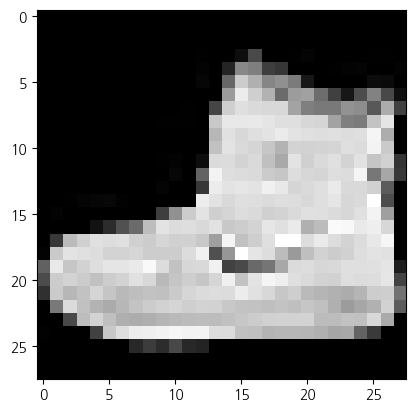

In [50]:
plt.imshow(x[0], cmap="gray")
plt.show()

In [91]:
## DataLoader 생성
fmnist_train_loader = DataLoader(fmnist_trainset, batch_size=128, 
                                 shuffle=True, drop_last=True)
fmnist_test_loader = DataLoader(fmnist_testset, batch_size=128)

In [92]:
# 모델 정의
class FashionMNISTModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(28*28, 2048)
        self.lr2 = nn.Linear(2048, 1024)
        self.lr3 = nn.Linear(1024, 512)
        self.lr4 = nn.Linear(512, 256)
        self.lr5 = nn.Linear(256, 128)
        self.lr6 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10) #out_feature: 10 - 10개 class별 확률.
    def forward(self, X):
        out = nn.Flatten()(X)
        out = nn.ReLU()(self.lr1(out))
        out = nn.ReLU()(self.lr2(out))
        out = nn.ReLU()(self.lr3(out))
        out = nn.ReLU()(self.lr4(out))
        out = nn.ReLU()(self.lr5(out))
        out = nn.ReLU()(self.lr6(out))
        out = self.output(out)
#         nn.Softmax()(out)
        # 다중분류의 output는 Softmax()함수로 계산해서 확률로 만들어서 출력해야 한다.
        # 모델에서는 Linear를 통과한 결과를 반환.
        # loss함수인 CrossEntropyLoss() 에서 softmax를 적용한다. 
        return out

In [93]:
f_model = FashionMNISTModel()
f_model

FashionMNISTModel(
  (lr1): Linear(in_features=784, out_features=2048, bias=True)
  (lr2): Linear(in_features=2048, out_features=1024, bias=True)
  (lr3): Linear(in_features=1024, out_features=512, bias=True)
  (lr4): Linear(in_features=512, out_features=256, bias=True)
  (lr5): Linear(in_features=256, out_features=128, bias=True)
  (lr6): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [94]:
torchinfo.summary(f_model, (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModel                        [128, 10]                 --
├─Linear: 1-1                            [128, 2048]               1,607,680
├─Linear: 1-2                            [128, 1024]               2,098,176
├─Linear: 1-3                            [128, 512]                524,800
├─Linear: 1-4                            [128, 256]                131,328
├─Linear: 1-5                            [128, 128]                32,896
├─Linear: 1-6                            [128, 64]                 8,256
├─Linear: 1-7                            [128, 10]                 650
Total params: 4,403,786
Trainable params: 4,403,786
Non-trainable params: 0
Total mult-adds (M): 563.68
Input size (MB): 0.40
Forward/backward pass size (MB): 4.14
Params size (MB): 17.62
Estimated Total Size (MB): 22.16

In [95]:
# 추정
i = torch.ones((2, 1, 28, 28), dtype=torch.float32)
# i.shape
y_hat = f_model(i)
print(y_hat.shape)
print(y_hat[0])
print(y_hat[0].sum().item(), y_hat[0].argmax(dim=-1).item())

torch.Size([2, 10])
tensor([-0.0704,  0.1061, -0.0297, -0.0479, -0.0593,  0.0345,  0.0791,  0.0875,
        -0.0969, -0.0795], grad_fn=<SelectBackward0>)
-0.0765145793557167 1


In [96]:
# 모델이 추정한 결과의 class를 알고 싶을 경우는 Softmax를 계산할 필요 없다.
# 모델의 추정 확률을 알고 싶을 경우 softmax를 계산한다.
y_hat2 = nn.Softmax(dim=-1)(y_hat[0])
print(y_hat2)
print(y_hat2.sum().item(), y_hat2.argmax(dim=-1).item())

tensor([0.0937, 0.1117, 0.0976, 0.0958, 0.0947, 0.1040, 0.1088, 0.1097, 0.0912,
        0.0928], grad_fn=<SoftmaxBackward0>)
0.9999999403953552 1


In [97]:
#### 학습
import time
device = "cpu"
# 모델 생성 + device 이동
fmnist_model = FashionMNISTModel().to(device)
# loss -> 다중분류: CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(fmnist_model.parameters(), lr=0.001)

# 결과저장할 리스트
train_loss_list = []
val_loss_list = []
val_acc_list = []

####################
# 가장 성능 좋은 epoch의 모델을 학습도중 저장. -> 성능이 개선될때 마다 저장.
# 필요한 변수들 정의
####################
best_score = torch.inf # 학습중 가장 좋은 평가지표(val_loss)를 저장.
save_model_path = "models/fashion_mnist_best_model.pt"

####################
# 조기종료 (Eearly Stopping) - 특정 epoch동안 성능 개선이 없으면 학습을 중단.
####################
patience = 10   # 성능 개선 여부를 몇 epoch동안 확인 할 것인지.
trigger_cnt = 0 # 몇 epoch째 성능개선을 기다리는지를 저장할 변수.

N_EPOCH = 1000
s = time.time()
for epoch in range(N_EPOCH): #에폭 학습
    ########### 학습
    fmnist_model.train()
    train_loss = 0.0
    for X, y in fmnist_train_loader:
        X, y = X.to(device), y.to(device)
        
        pred = fmnist_model(X)
        loss = loss_fn(pred, y) # pred: Softmax(), y: one hot encoding 처리
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(fmnist_train_loader)   # 평균 loss 계산
    #### 1 epoch 학습 종료
     
    ############ 검증
    fmnist_model.eval()
    val_loss = 0.0
    val_acc = 0.0
    
    with torch.no_grad():
        for X_val, y_val in fmnist_test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            pred_val = fmnist_model(X_val)  # Softmax 적용 전. -> loss는 이 값으로 계산.
            pred_label = pred_val.argmax(dim=-1)  # accuracy  계산은 이 값으로 한다.
            
            # val-loss
            loss_val = loss_fn(pred_val, y_val)
            val_loss += loss_val.item()
            # val-accuracy
            val_acc += torch.sum(pred_label == y_val).item()  #현 배치에서 맞은 것의 개수
        # val_loss, val_acc의 평균
        val_loss /= len(fmnist_test_loader)  # step 수로 나눔.
        val_acc /= len(fmnist_test_loader.dataset) # 총 데이터 개수로 나눔.
    
    # 현재 Epoch에 대한 학습, 검증 종료
    print(f"[{epoch+1}/{N_EPOCH}] train loss: {train_loss:.5f} val loss: {val_loss:.5f} val_accuracy: {val_acc:.5f}")
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    ######################################## 
    #  조기종료, 모델 저장 처리
    #   현 epoch의 val_loss가 best_score보다 개선된 경우.(작은 경우)
    #######################################
    if val_loss < best_score: #성능개선
        # 저장/조기종료
        print(f"저장 : {epoch+1} epoch - 이전 best_score: {best_score}, 현재 score: {val_loss}")
        best_score = val_loss
        torch.save(fmnist_model, save_model_path)
        trigger_cnt = 0
        
    else:
        # 저장안하기/trigger_cnt 를 증가.=>조기종료
        trigger_cnt += 1
        if patience == trigger_cnt:
            print(f"조기종료: epoch-{epoch+1}. {best_score:.5f}에서 개선이 안됨.")
            break
    
e = time.time()
print(f'학습에 걸린시간: {e-s}초')

[1/1000] train loss: 0.61363 val loss: 0.52008 val_accuracy: 0.81630
저장 : 1 epoch - 이전 best_score: inf, 현재 score: 0.5200847425038302


KeyboardInterrupt: 

In [ ]:
1182/60

In [ ]:
# 결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_list)
plt.title("Validation Accuracy")
plt.show()

In [ ]:
fmnist_load_model = torch.load(save_model_path)

In [ ]:
val_loss, val_acc = 0.0, 0.0
with torch.no_grad():
    for X_val, y_val in fmnist_test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)

        pred_val = fmnist_load_model(X_val)  # Softmax 적용 전. -> loss는 이 값으로 계산.
        pred_label = pred_val.argmax(dim=-1)  # accuracy  계산은 이 값으로 한다.

        # val-loss
        loss_val = loss_fn(pred_val, y_val)
        val_loss += loss_val.item()
        # val-accuracy
        val_acc += torch.sum(pred_label == y_val).item()  #현 배치에서 맞은 것의 개수
    # val_loss, val_acc의 평균
    val_loss /= len(fmnist_test_loader)  # step 수로 나눔.
    val_acc /= len(fmnist_test_loader.dataset) # 총 데이터 개수로 나눔.

In [43]:
val_loss, val_acc

(0.31778975510144536, 0.8926)

## 위스콘신 유방암 데이터셋 - 이진분류(Binary Classification) 문제

- **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현
        - output layer: units=1, activation='sigmoid'
        - loss: binary_crossentropy
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer: units=2, activation='softmax', y(정답)은 one hot encoding 처리
        - loss: categorical_crossentropy
        
- 위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
- Feature
    - 종양에 대한 다양한 측정값들
- Target의 class
    - 0 - malignant(악성종양)
    - 1 - benign(양성종양)

In [60]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)
y = y.reshape(-1, 1)  # 2차원으로 변경. ==> 모델 출력 shape과 맞춰준다. 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
# scaling
scaler = StandardScaler()
X_train_tensor = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test_tensor = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [61]:
y_train_tensor.shape, y_test_tensor.shape

(torch.Size([426, 1]), torch.Size([143, 1]))

In [62]:
# Dataset - 데이터셋이 Tensor 객체로 메모리에 loading된 경우
wb_train_set = TensorDataset(X_train_tensor, y_train_tensor)
wb_test_set = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader
wb_train_loader = DataLoader(wb_train_set, batch_size=len(wb_train_set),
                             shuffle=True, drop_last=True)
wb_test_loader = DataLoader(wb_test_set, batch_size=len(wb_test_set))

In [63]:
x, y = next(iter(wb_train_loader))
x.shape, y.shape

(torch.Size([426, 30]), torch.Size([426, 1]))

In [64]:
x.mean(dim=0), x.std(dim=0)

(tensor([ 4.4773e-09,  4.4773e-09,  2.2387e-09,  8.9547e-09,  0.0000e+00,
          2.2387e-09, -2.2387e-09,  4.4773e-09, -2.2387e-09,  4.4773e-09,
         -8.9547e-09, -4.4773e-09,  2.2387e-09, -2.2387e-09,  4.4773e-09,
         -2.2387e-09, -2.2387e-09,  2.2387e-09,  6.7160e-09, -2.2387e-09,
          2.2387e-09, -2.2387e-09,  2.2387e-09,  6.7160e-09,  5.5967e-10,
         -1.1193e-09, -2.2387e-09,  2.2387e-09,  2.2387e-09, -1.1193e-09]),
 tensor([1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012,
         1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012,
         1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012,
         1.0012, 1.0012, 1.0012]))

In [65]:
index_to_class = ["악성종양", "양성종양"]
class_to_index = {"악성종양":0, "양성종양":1}

In [66]:
X.shape

(569, 30)

In [67]:
# 모델정의
class BreastCancerModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(30, 32)
        self.lr2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)  # 출력- 값 1개 (positive의 확률을 출력)
        
    def forward(self, X):
        out = nn.ReLU()(self.lr1(X))
        out = nn.ReLU()(self.lr2(out))
        out = self.output(out)   
        # 2진분류->positive 확률을 출력 -> output의 출력결과를 logistic 함수에 입력
        out = nn.Sigmoid()(out)
        return out
    

In [68]:
bc_model_tmp = BreastCancerModel()
tmp_x = torch.ones(5, 30)
y_tmp = bc_model_tmp(tmp_x)
y_tmp 

tensor([[0.5580],
        [0.5580],
        [0.5580],
        [0.5580],
        [0.5580]], grad_fn=<SigmoidBackward0>)

In [70]:
import time
### 학습
N_EPOCH = 500
train_loss_list, val_loss_list, val_acc_list = [], [], []

model = BreastCancerModel().to(device)
loss_fn = nn.BCELoss()  # 이진분류-positive확률출력모델의 loss-Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# early stopping, 모델 저장을 위한 변수
best_score = torch.inf
save_model_path_bc = 'models/breast_cancer_best_model.pt'

patience = 10 # 개선될때까지 몇번 기다릴지.
trigger_cnt = 0 # 몇번째 기다렸는지 

s = time.time()
for epoch in range(N_EPOCH):
    #### 학습
    model.train()
    train_loss = 0.0
    for X, y in wb_train_loader:
        X, y = X.to(device), y.to(device)
        # 추정                         
        pred = model(X) # positive의 확률 - loss 계산
        loss = loss_fn(pred, y)
        # 파라미터 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    # 학습 종료 -> train loss 평균
    train_loss /= len(wb_train_loader)
    #### 검증
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for X_val, y_val in wb_test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            # 추정
            pred_val = model(X_val)  # positive의 확률  0.XXXX -> loss계산
                        
            #type(타입)=>타입변환. bool=>정수. True->1, False->0
            pred_label = (pred_val >= 0.5).type(torch.int32) # accuracy 계산
               
            loss_val = loss_fn(pred_val, y_val)
            val_loss += loss_val.item()
            val_acc +=  torch.sum(pred_label == y_val).item()
        
        val_loss /= len(wb_test_loader)
        val_acc /= len(wb_test_loader.dataset)
    
    # 현재 epoch 학습/검증 종료
    # 로그출력
    print(f"[{epoch+1}/{N_EPOCH}] train loss: {train_loss}, val loss: {val_loss}, val accuracy: {val_acc}")
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    #### early stopping, model 저장 처리.
    if val_loss < best_score: # 성능 개선
        print(f"{epoch+1} epoch에서 저장. 이전 score: {best_score}, 현재 score: {val_loss}")
        best_score = val_loss
        torch.save(model, save_model_path_bc)
        trigger_cnt = 0
    else: # 현재 epoch에서 성능 개선이 안됨.
        trigger_cnt += 1
        if patience == trigger_cnt: # 조기 종료
            print(f"{epoch+1} epoch에서 종료. {best_score}에서 성능이 개선되지 않음.")
            break

e = time.time()
print(f"{e-s}초 걸림")


[1/500] train loss: 0.7147631645202637, val loss: 0.7080258727073669, val accuracy: 0.2867132867132867
1 epoch에서 저장. 이전 score: inf, 현재 score: 0.7080258727073669
[2/500] train loss: 0.7085423469543457, val loss: 0.7021784782409668, val accuracy: 0.36363636363636365
2 epoch에서 저장. 이전 score: 0.7080258727073669, 현재 score: 0.7021784782409668
[3/500] train loss: 0.702426552772522, val loss: 0.6962939500808716, val accuracy: 0.43356643356643354
3 epoch에서 저장. 이전 score: 0.7021784782409668, 현재 score: 0.6962939500808716
[4/500] train loss: 0.6963770985603333, val loss: 0.6904833316802979, val accuracy: 0.5244755244755245
4 epoch에서 저장. 이전 score: 0.6962939500808716, 현재 score: 0.6904833316802979
[5/500] train loss: 0.6903742551803589, val loss: 0.6847456693649292, val accuracy: 0.6223776223776224
5 epoch에서 저장. 이전 score: 0.6904833316802979, 현재 score: 0.6847456693649292
[6/500] train loss: 0.6844336986541748, val loss: 0.6790831089019775, val accuracy: 0.6783216783216783
6 epoch에서 저장. 이전 score: 0.68474

[63/500] train loss: 0.22081272304058075, val loss: 0.24332265555858612, val accuracy: 0.9440559440559441
63 epoch에서 저장. 이전 score: 0.2488590031862259, 현재 score: 0.24332265555858612
[64/500] train loss: 0.2149229794740677, val loss: 0.23799341917037964, val accuracy: 0.9440559440559441
64 epoch에서 저장. 이전 score: 0.24332265555858612, 현재 score: 0.23799341917037964
[65/500] train loss: 0.20923563838005066, val loss: 0.2328455001115799, val accuracy: 0.9440559440559441
65 epoch에서 저장. 이전 score: 0.23799341917037964, 현재 score: 0.2328455001115799
[66/500] train loss: 0.2037457972764969, val loss: 0.22790281474590302, val accuracy: 0.9440559440559441
66 epoch에서 저장. 이전 score: 0.2328455001115799, 현재 score: 0.22790281474590302
[67/500] train loss: 0.1984550952911377, val loss: 0.22317680716514587, val accuracy: 0.9440559440559441
67 epoch에서 저장. 이전 score: 0.22790281474590302, 현재 score: 0.22317680716514587
[68/500] train loss: 0.19335757195949554, val loss: 0.21865706145763397, val accuracy: 0.94405594

[118/500] train loss: 0.07699336111545563, val loss: 0.11968172341585159, val accuracy: 0.9440559440559441
118 epoch에서 저장. 이전 score: 0.12042113393545151, 현재 score: 0.11968172341585159
[119/500] train loss: 0.07605697214603424, val loss: 0.11896611005067825, val accuracy: 0.9440559440559441
119 epoch에서 저장. 이전 score: 0.11968172341585159, 현재 score: 0.11896611005067825
[120/500] train loss: 0.07514457404613495, val loss: 0.11827803403139114, val accuracy: 0.9440559440559441
120 epoch에서 저장. 이전 score: 0.11896611005067825, 현재 score: 0.11827803403139114
[121/500] train loss: 0.07425709068775177, val loss: 0.11761629581451416, val accuracy: 0.9440559440559441
121 epoch에서 저장. 이전 score: 0.11827803403139114, 현재 score: 0.11761629581451416
[122/500] train loss: 0.07339339703321457, val loss: 0.11697711795568466, val accuracy: 0.9440559440559441
122 epoch에서 저장. 이전 score: 0.11761629581451416, 현재 score: 0.11697711795568466
[123/500] train loss: 0.07255279272794724, val loss: 0.11635945737361908, val ac

[168/500] train loss: 0.048997364938259125, val loss: 0.10193483531475067, val accuracy: 0.958041958041958
168 epoch에서 저장. 이전 score: 0.10210022330284119, 현재 score: 0.10193483531475067
[169/500] train loss: 0.048672404140233994, val loss: 0.10177493095397949, val accuracy: 0.958041958041958
169 epoch에서 저장. 이전 score: 0.10193483531475067, 현재 score: 0.10177493095397949
[170/500] train loss: 0.04835193604230881, val loss: 0.10161653161048889, val accuracy: 0.958041958041958
170 epoch에서 저장. 이전 score: 0.10177493095397949, 현재 score: 0.10161653161048889
[171/500] train loss: 0.04803624749183655, val loss: 0.10147170722484589, val accuracy: 0.958041958041958
171 epoch에서 저장. 이전 score: 0.10161653161048889, 현재 score: 0.10147170722484589
[172/500] train loss: 0.04772533103823662, val loss: 0.10133832693099976, val accuracy: 0.958041958041958
172 epoch에서 저장. 이전 score: 0.10147170722484589, 현재 score: 0.10133832693099976
[173/500] train loss: 0.04741829261183739, val loss: 0.10121806710958481, val accur

[227/500] train loss: 0.035434093326330185, val loss: 0.09903992712497711, val accuracy: 0.958041958041958
227 epoch에서 저장. 이전 score: 0.0990624725818634, 현재 score: 0.09903992712497711
[228/500] train loss: 0.035263221710920334, val loss: 0.09902159124612808, val accuracy: 0.958041958041958
228 epoch에서 저장. 이전 score: 0.09903992712497711, 현재 score: 0.09902159124612808
[229/500] train loss: 0.035092633217573166, val loss: 0.09900838881731033, val accuracy: 0.958041958041958
229 epoch에서 저장. 이전 score: 0.09902159124612808, 현재 score: 0.09900838881731033
[230/500] train loss: 0.03492285683751106, val loss: 0.09900025278329849, val accuracy: 0.958041958041958
230 epoch에서 저장. 이전 score: 0.09900838881731033, 현재 score: 0.09900025278329849
[231/500] train loss: 0.03475331887602806, val loss: 0.09899198263883591, val accuracy: 0.958041958041958
231 epoch에서 저장. 이전 score: 0.09900025278329849, 현재 score: 0.09899198263883591
[232/500] train loss: 0.0345846526324749, val loss: 0.09897935390472412, val accura

In [71]:
torchinfo.summary(model, (100, 30))

Layer (type:depth-idx)                   Output Shape              Param #
BreastCancerModel                        [100, 1]                  --
├─Linear: 1-1                            [100, 32]                 992
├─Linear: 1-2                            [100, 16]                 528
├─Linear: 1-3                            [100, 1]                  17
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
Total mult-adds (M): 0.15
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

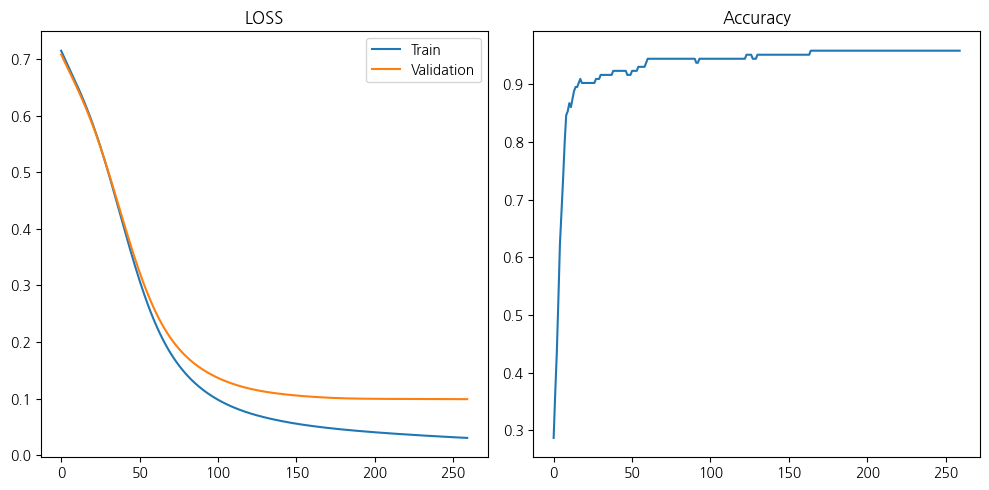

In [72]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("LOSS")
plt.plot(train_loss_list, label="Train")
plt.plot(val_loss_list, label="Validation")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(val_acc_list)
plt.tight_layout()
plt.show()

In [73]:
# 평가
load_model = torch.load(save_model_path_bc)
load_model

BreastCancerModel(
  (lr1): Linear(in_features=30, out_features=32, bias=True)
  (lr2): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)

In [74]:
val_loss, val_acc = 0.0, 0.0
with torch.no_grad():
    for X_val, y_val in wb_test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)

        # 추정
        pred_val = load_model(X_val)  # positive의 확률  0.XXXX -> loss계산

        #type(타입)=>타입변환. bool=>정수. True->1, False->0
        pred_label = (pred_val >= 0.5).type(torch.int32) # accuracy 계산

        loss_val = loss_fn(pred_val, y_val)
        val_loss += loss_val.item()
        val_acc +=  torch.sum(pred_label == y_val).item()

    val_loss /= len(wb_test_loader)
    val_acc /= len(wb_test_loader.dataset)

In [75]:
print(val_loss, val_acc)

0.09878537803888321 0.958041958041958


In [76]:
from module import train

In [77]:
train?

In [102]:
model = BreastCancerModel()
loss_fn = nn.BCELoss()  # 이진분류-positive확률출력모델의 loss-Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
result= train.fit(wb_train_loader,wb_test_loader,
             model,
             loss_fn,
             optimizer,
             100,
             save_model_path='models/wb_model.pt',
             patience=5,
            device=device )

AttributeError: 'int' object has no attribute 'to'

TypeError: 'DataLoader' object is not subscriptable

In [98]:
model2 = FashionMNISTModel()
loss_fn2 = nn.CrossEntropyLoss()
optimizer2= torch.optim.Adam(model2.parameters(),lr=0.001)
result2 = train.fit(fmnist_train_loader,fmnist_test_loader,
             model2,
             loss_fn2,
             optimizer2,
             5,
             save_model_path='models/fmnist_model.pt',
             early_stopping=False,
             device=device,
             mode='multi')

AttributeError: 'int' object has no attribute 'to'